In [46]:
using Revise

In [47]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using RigidBodySim
using Flux
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models
using DataFrames
using Blink

In [48]:
robot = BoxAtlas(add_contacts=true)
position_bounds(findjoint(mechanism(robot), "floating_base")) .= RigidBodyDynamics.Bounds(-Inf, Inf)
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(2, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 9498`, ProcessRunning), TCPSocket(RawFD(74) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(4, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(55) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 4, Nullable{Any}(true))))

In [49]:
interval_net, lqrsol = jldopen("boxatlas-regularized.jld2") do file
    file["net"], file["lqrsol"]
end
interval_net_mpc = LearningMPC.mpc_controller(robot, LearningMPC.LearnedCost(lqrsol, interval_net), Δt=0.05)

upperbound_net = jldopen("boxatlas-regularized-upperbound.jld2") do file
    file["net"]
end
upperbound_net_mpc = LearningMPC.mpc_controller(robot, LearningMPC.LearnedCost(lqrsol, upperbound_net), Δt=0.05)

lowerbound_net = jldopen("boxatlas-regularized-lowerbound.jld2") do file
    file["net"]
end
lowerbound_net_mpc = LearningMPC.mpc_controller(robot, LearningMPC.LearnedCost(lqrsol, lowerbound_net), Δt=0.05)

policy_net = jldopen("boxatlas-regularized-mimic.jld2") do file
    file["net"]
end

policy_net_controller = let net = policy_net
    function (τ, t, x)
        τ .= Flux.Tracker.data(net(LearningMPC.qv(x)))
    end
end

lqr_mpc = LearningMPC.mpc_controller(robot, lqrsol, Δt=0.05);

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [50]:
using DataFrames
using Plots; gr()

Plots.GRBackend()

In [51]:
policies = [(lqrsol, "LQR"), 
            (lqr_mpc, "MPC + LQR cost"),
            (policy_net_controller, "Policy Net"), 
            (interval_net_mpc, "MPC + Learned Interval"),
            (upperbound_net_mpc, "MPC + Learned Upper Bound"),
            (lowerbound_net_mpc, "MPC + Learned Lower Bound")
]

tables = map(policies) do args
    controller, label = args
    LearningMPC.run_evaluations(
        controller,
        label,
        robot,
        lqrsol,
        [(1, [0])],
        [(1, linspace(-1.5, 1.5, 31)), (3, linspace(-π/2, π/2, 5))]; 
        mvis=mvis,
        horizon=400)
end
cost_table = vcat(tables...)

Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:25WARNING: Instability detected. Aborting
Progress: 100%|█████████████████████████████████████████| Time: 0:05:60
Progress: 100%|█████████████████████████████████████████| Time: 0:56:31
Progress:  23%|█████████                                |  ETA: 0:05:49WARNING: Instability detected. Aborting
Progress:  25%|██████████                               |  ETA: 0:05:35WARNING: Instability detected. Aborting
Progress:  39%|████████████████                         |  ETA: 0:04:10WARNING: Instability detected. Aborting
Progress:  66%|███████████████████████████              |  ETA: 0:02:09WARNING: Instability detected. Aborting
Progress: 100%|█████████████████████████████████████████| Time: 0:06:04
Progress:  23%|█████████                                |  ETA: 0:43:28WARNING: Instability detected. Aborting
Progress: 100%|█████████████████████████████████████████| Time: 0:59:01
Progress:  84%|███████████████████████████████

,controller,q0,v0,Δt,horizon,qf,vf,running_cost,terminal_cost
1,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.5, 0.0, -1.5708, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-1.32261, -0.350023, 3.14234, 0.0429699, 0.0004654, 0.785509, -0.0501014, 0.800029, 0.800035, 0.950195, 0.474793]","[0.0354237, -0.0055292, -0.0261298, 0.0332315, -0.0327945, 0.00022455, -6.49967e-5, 0.000173254, -0.0018425, 0.000193072, 0.000331276]",27349.6,35415.8
2,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.4, 0.0, -1.5708, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-1.67297, -0.349679, 3.14283, 0.0343728, 0.00605332, 0.785505, -0.0501013, 0.799392, 0.800021, 0.950199, 0.474799]","[0.013476, 0.0554483, -0.0852643, -0.0255065, -0.0494268, -6.6966e-5, 2.72547e-5, 0.119439, 0.000734966, -7.31024e-5, -0.000112311]",26197.6,39215.8
3,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.3, 0.0, -1.5708, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-1.81494, -0.348076, 3.15203, 0.119736, 0.0277322, 0.78548, -0.0500936, 0.799345, 0.800251, 0.950173, 0.474756]","[-0.396881, 0.307546, -0.100538, -0.576736, 0.567585, -0.00723447, 0.0019347, 0.212708, 0.0652198, -0.00841267, -0.0156416]",23383.6,41074.9
4,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.2, 0.0, -1.5708, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[0.35214, 0.629761, 0.0901815, 0.492531, 0.153777, 0.782176, 0.528351, 0.556072, 0.536484, 0.803192, 0.785662]","[-0.242944, 0.00734011, -0.393753, -0.670264, 0.475606, -0.627072, 0.712595, 0.165513, -0.15474, -0.11123, 0.17621]",755.709,31.8345
5,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.1, 0.0, -1.5708, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-0.379403, 0.663786, -0.180197, 0.0611405, 0.639498, 0.37686, 0.785208, 0.553369, 0.49438, 0.805394, 0.782831]","[-0.0233169, 0.0523515, 0.0906407, -0.00486953, -0.158509, 0.138644, -0.0720095, 0.033422, 0.106311, 0.378069, 0.0364228]",598.327,17.6346
6,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.0, 0.0, -1.5708, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[0.148679, -0.350626, -3.14124, -9.72913e-6, 0.00435552, -0.0501002, 0.785508, 0.800063, 0.800064, 0.474782, 0.950187]","[0.000194514, -0.00478812, -0.00312718, -0.000113545, 0.00115371, 1.29143e-5, -0.000153511, -0.000578215, -0.000956491, 0.00021516, 0.000142556]",19366.6,24090.1
7,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-0.9, 0.0, -1.5708, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-0.577399, 0.745554, -0.197288, 0.000768596, 0.525228, 0.0763317, 0.785406, 0.658472, 0.673315, 0.796825, 0.871035]","[-0.0299954, -0.0141176, -0.0779829, -0.0780575, 0.0641389, -0.0387881, -0.00227407, 0.0118038, -0.0113641, -0.315211, 0.282289]",244.827,15.9287
8,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-0.8, 0.0, -1.5708, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-0.474914, 0.465232, -0.241139, 0.230484, 0.576775, 0.785416, 0.785417, 0.399999, 0.4, 0.950081, 0.513989]","[-1.60744e-5, 1.01337e-5, 1.60851e-5, -0.0144936, 0.0216438, -1.58777e-7, -5.82303e-7, 1.15136e-9, -1.79586e-8, -7.00775e-7, 1.97228e-5]",406.133,36.9356
9,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-0.7, 0.0, -1.5708, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-0.0414873, -0.346851, -3.1483, 0.0112401, 0.135266, -0.0501052, 0.785539, 0.800014, 0.800177, 0.474781, 0.950181]","[0.169698, 0.120729, -0.00439369, -0.169068, -0.231209, -0.000483721, 0.00397777, -0.000250053, 0.0205903, -0.00247521, -0.0024917]",16977.9,22588.9
10,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-0.6, 0.0, -1.5708, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-0.766395, 0.767882, -0.330515, -3.12441e-6, 0.854579, 0.00151644, 0.785405, 0.674817, 0.589233, 0.851017, 0.815411]","[-0.0221774, -0.00634555, 0.02084, 0.00140141, 

In [52]:
@save "cost_table.jld2" cost_table

In [53]:
using StatsBase: geomean

In [54]:
function geostd(xs)
    μ = geomean(xs)
    exp(sqrt(sum(x -> log(x / μ)^2, xs) / length(xs)))
end

geostd (generic function with 1 method)

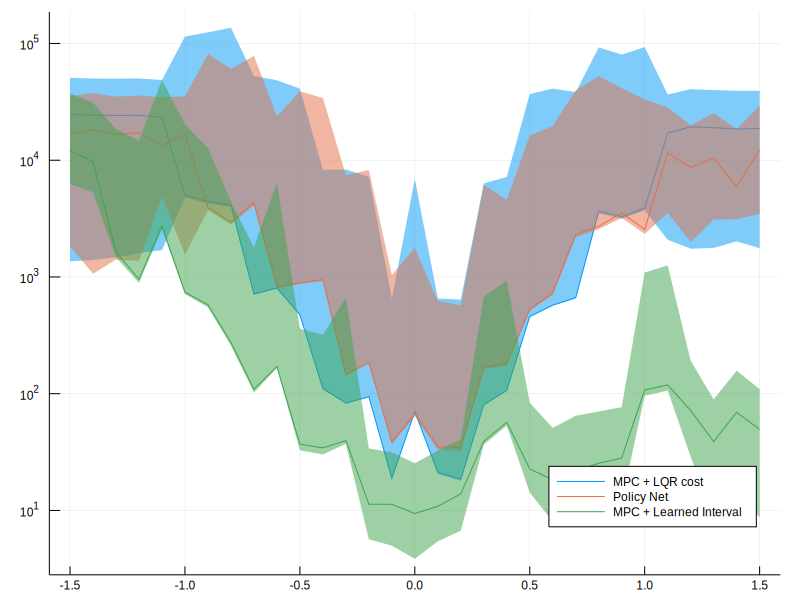

In [58]:
plt = plot(yscale=:log, legend=:bottomright, size=(800, 600))
# ylims!(plt, 1e-2, 1e6)
for label in ["MPC + LQR cost", "Policy Net", "MPC + Learned Interval"]
    samples = Dict{Float64, Vector{Float64}}()
    for row in eachrow(cost_table)
        if row[:controller] == label
            x = row[:v0][1]
            y = row[:running_cost][1]
            push!(get!(() -> Float64[], samples, x), y)
        end
    end
    sorted = sort(collect(samples); by = first)
    xs = first.(sorted)
    ys = geomean.(last.(sorted))
    σs = geostd.(last.(sorted))
    plot!(plt, xs, ys, label=label, ribbon=(ys ./ σs, ys .* σs))
end
plt

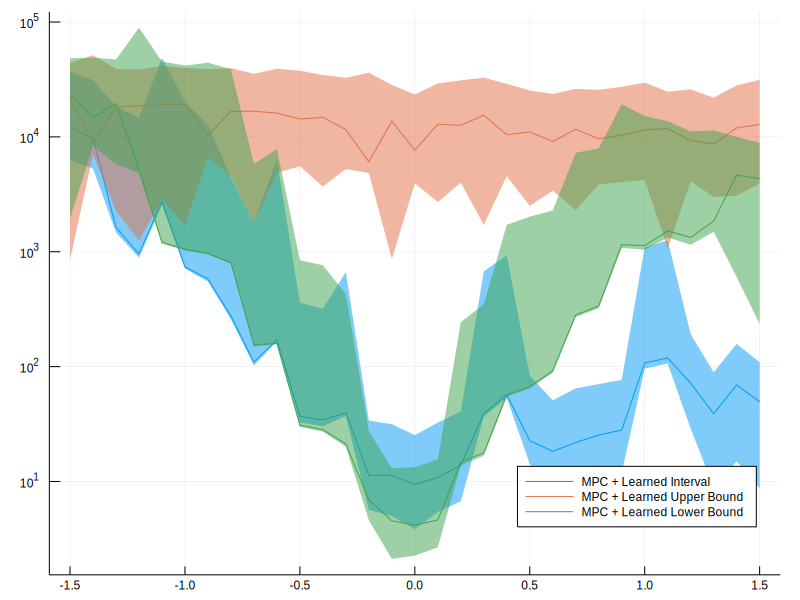

In [60]:
plt = plot(yscale=:log, legend=:bottomright, size=(800, 600))
# ylims!(plt, 1e-2, 1e6)
for label in ["MPC + Learned Interval", "MPC + Learned Upper Bound", "MPC + Learned Lower Bound"]
    samples = Dict{Float64, Vector{Float64}}()
    for row in eachrow(cost_table)
        if row[:controller] == label
            x = row[:v0][1]
            y = row[:running_cost][1]
            push!(get!(() -> Float64[], samples, x), y)
        end
    end
    sorted = sort(collect(samples); by = first)
    xs = first.(sorted)
    ys = geomean.(last.(sorted))
    σs = geostd.(last.(sorted))
    plot!(plt, xs, ys, label=label, ribbon=(ys ./ σs, ys .* σs))
end
plt

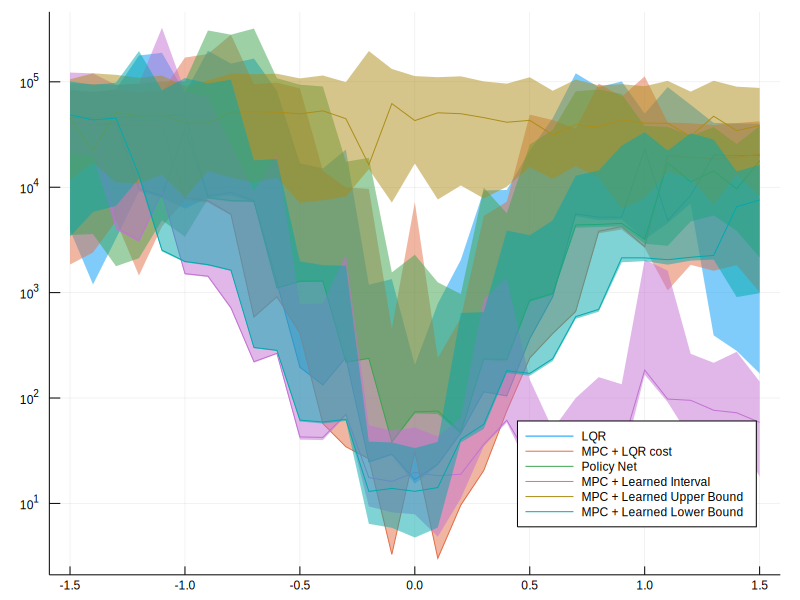

In [56]:
plt = plot(yscale=:log, legend=:bottomright, size=(800, 600))
# ylims!(plt, 1e-2, 1e6)
for (controller, label) in policies
    samples = Dict{Float64, Vector{Float64}}()
    for row in eachrow(cost_table)
        if row[:controller] == label
            x = row[:v0][1]
            y = row[:terminal_cost][1]
            push!(get!(() -> Float64[], samples, x), y)
        end
    end
    sorted = sort(collect(samples); by = first)
    xs = first.(sorted)
    ys = geomean.(last.(sorted))
    σs = geostd.(last.(sorted))
    plot!(plt, xs, ys, label=label, ribbon=(ys ./ σs, ys .* σs))
#     ys = mean.(last.(sorted))
#     σs = std.(last.(sorted))
# #     @show xs ys σs
#     plot!(plt, xs, ys, label=label, ribbon=σs)
end
plt